In [284]:

%load_ext autoreload 
%autoreload 2 
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module
import matplotlib.pyplot as plt
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
market_features = pd.read_parquet('data/US/market_features.pq')


In [ ]:
market_data = pd.read_parquet('data/US/test_mkt_data.pq')
earnings = pd.read_parquet('data/US/test_earnings.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

In [60]:
test = earnings[['reportDate']].reset_index(level=1).sort_index()
test['reportDate'] = pd.to_datetime(test['reportDate'])
test = test.loc['2023':]

In [265]:
def profile (test,days_before,days_after,ret,variable):
    test['multi_idx'] = pd.MultiIndex.from_frame(test[['Ticker',variable]])
    df_cumulated_return = pd.DataFrame(index = np.arange(- days_before, days_after+1,1),columns = test['multi_idx'].unique(),dtype = np.float32)
    df_cumulated_return.columns = pd.MultiIndex.from_tuples(df_cumulated_return.columns.tolist())
    
    for i,row in test.iterrows():
        try :
            tt = ret.loc[row[variable] - pd.offsets.BDay(days_before) : row[variable] + pd.offsets.BDay(days_after),row.Ticker]
            up = np.arange(0,len(tt.loc[row[variable]:])-1,1)
            up = up.tolist()
            down = np.arange(-len(tt.loc[row[variable]:]),0,1)
            down = down.tolist()
            tt.index = down + up 
            df_cumulated_return.loc[:,row.multi_idx] = tt 
        except :
            pass 
    return df_cumulated_return

profile_earnings  = profile(test,20,30,ret= market_features['alpha_daily_returns'].unstack(),variable ='reportDate')

<Axes: >

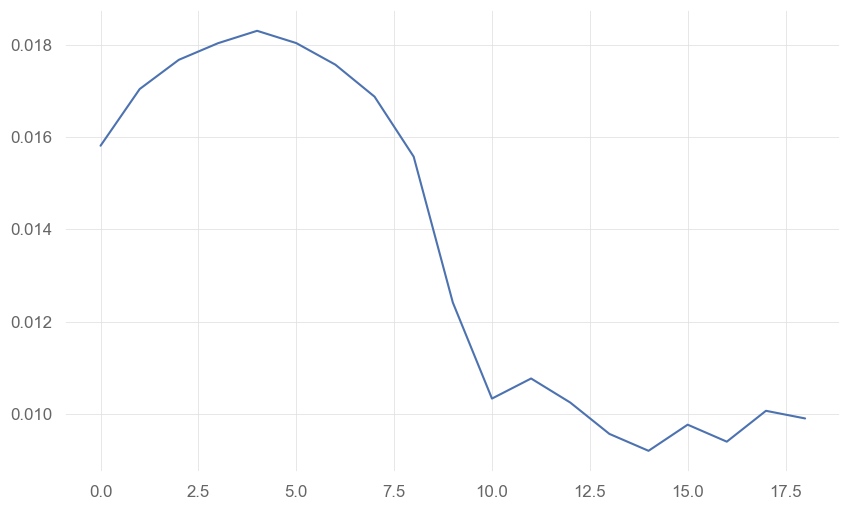

In [266]:
df = pd.DataFrame((profile_earnings.rolling(10).std().median(1).loc[0:])).reset_index()
df.columns = ['X','Y']
df['Y'] = df['Y']
df = df.dropna()
df['Y'].plot()

<Axes: xlabel='X'>

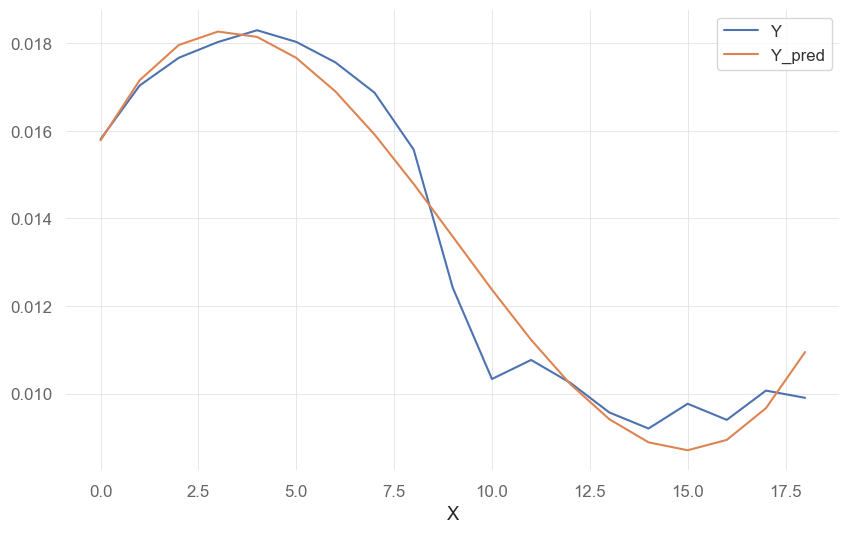

In [267]:
from scipy.optimize import curve_fit


def objective(x, a, b, c,d):
 return a * x**3 +b*x**2 + c*x +d

popt, _ = curve_fit(objective, df['X'], df['Y'])
a, b, c,d = popt
# use optimal parameters to calculate new values
y_new = objective(df['X'], a, b, c,d)
df['Y_pred'] = y_new
df.set_index('X').plot()

In [268]:
earnings_report = earnings.copy() 
earnings_report['reportDate'] = pd.to_datetime(earnings_report['reportDate'])
earnings_report['earnDate'] = earnings_report['reportDate']
earnings_report = earnings_report.set_index('reportDate',append=True)
earnings_report = earnings_report.droplevel(0).swaplevel().sort_index(level=0)
earnings_report.index.names = ['Date','Ticker']
earnings_report= earnings_report.drop_duplicates(keep='first')
earnings_report = earnings_report[~earnings_report.index.duplicated(keep=	'first')]

In [269]:
n_days_since_earnings = earnings_report['earnDate'].unstack().reindex_like(P).ffill()
n_days_since_earnings = - n_days_since_earnings.sub(n_days_since_earnings.index,0).apply(lambda x : x.dt.days)
benchmark =  n_days_since_earnings.apply(lambda x : objective(x,*popt))
benchmark = benchmark[n_days_since_earnings<20]
benchmark.stack().describe()

count    544185.000000
mean          0.013473
std           0.003459
min           0.008708
25%           0.009669
50%           0.013584
75%           0.016900
max           0.018267
dtype: float64

In [271]:
signal = market_features['alpha_daily_returns'].unstack().reindex_like(P).rolling(10).std() 
signal = signal - benchmark
signal.stack().describe()

count    426862.000000
mean          0.006065
std           0.044348
min          -0.016666
25%          -0.002939
50%           0.002142
75%           0.010138
max          14.689886
dtype: float64

Sharpe                     0.0
Daily Turnover (%)        44.6
biais (bp)                 0.1
Sharpe since 2022          1.1
biais  since 2022 (bp)     4.0
dtype: float64

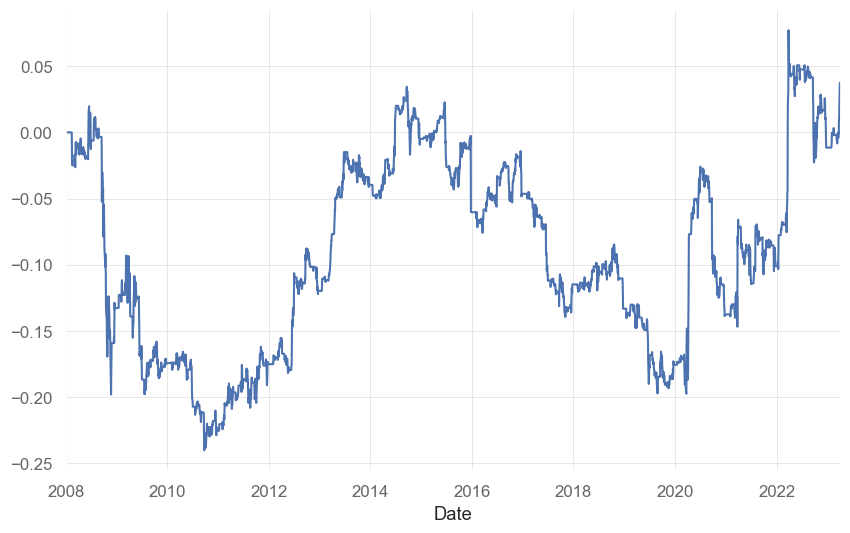

In [273]:
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal = signal[P]#.groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

In [286]:
%load_ext autoreload  
%autoreload 2
import requests 
import os

from utils import * 
ipos = master.equities.get_nearby_ipos()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
ipos[ipos['exchange'].isin(['Nasdaq','NYSE''NYSEArca'])]

,code,name,exchange,currency,start_date,filing_date,amended_date,price_from,price_to,offer_price,shares,deal_type
8,CHSN.US,Chanson International Holding Class A Ordinary...,Nasdaq,USD,2023-03-28,None,None,0.0,0.0,0.0,0,Expected
9,UTHY.US,US Treasury 30 Year Bond ETF,Nasdaq,USD,2023-03-28,2023-03-28,2023-03-28,0.0,0.0,0.0,0,Expected
10,UFIV.US,US Treasury 5 Year Note ETF,Nasdaq,USD,2023-03-28,2023-03-28,2023-03-28,0.0,0.0,0.0,0,Expected
11,UTRE.US,US Treasury 3 Year Note ETF,Nasdaq,USD,2023-03-28,2023-03-28,2023-03-28,0.0,0.0,0.0,0,Expected
12,UTWY.US,US Treasury 20 Year Bond ETF,Nasdaq,USD,2023-03-28,2023-03-28,2023-03-28,0.0,0.0,0.0,0,Expected
...,...,...,...,...,...,...,...,...,...,...,...,...
1692,IBAT.US,iShares Energy Storage & Materials ETF,Nasdaq,USD,2024-03-21,2024-03-21,2024-03-21,0.0,0.0,0.0,0,Expected
1693,BKHAU.US,Black Hawk Acquisition Corporation Units,Nasdaq,USD,2024-03-21,2024-03-21,2024-03-21,0.0,0.0,0.0,5917159,Priced
1695,MRNOW.US,Murano Global Investments PLC Warrants,Nasdaq,USD,2024-03-21,2024-03-21,2024-03-21,0.0,0.0,0.0,0,Expected
1699,COOT.US,Australian Oilseeds Holdings Limited Ordinary ...,Nasdaq,USD,2024-03-22,2024-03-22,2024-03-22,0.0,0.0,0.0,0,Expected
